#Описание
Данная тетрадка содержит описание данных задачи.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#time_series.csv
Данный файл содержит временные ряды истории обращений к файлам за 78 недель и их метки. Метка **0** - популярные файлы, **1** - непопулярные файлы. Важно надежно определять непопулярные файлы.


###Чтение файла.

In [4]:
time_series = pd.read_csv('../Data/time_series.csv')
time_series.irow(range(1,5))

,Unnamed: 0,Name,1,2,3,4,5,6,7,8,...,70,71,72,73,74,75,76,77,78,Label
1,1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,234,474,0,...,0,0,0,0,0,0,0,0,0,1
3,3,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


###Примеры временных рядов

In [5]:
periods_str = [str(i) for i in range(1,79)]
periods = range(1,79)

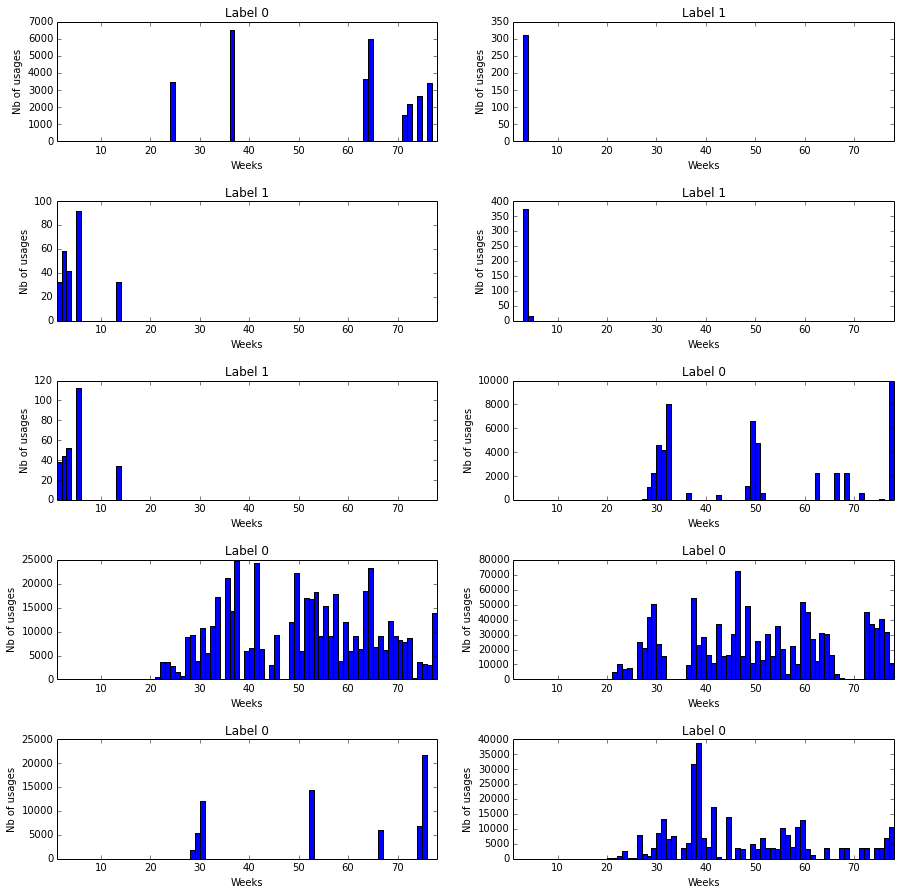

In [6]:
plt.figure(figsize=(15,15))
plt.subplots_adjust( hspace=.5)
for i in range(48,58):#менять тут
    one_time_serie = time_series[periods_str].irow(i).values
    one_label = str(time_series['Label'].irow(i))
    plt.subplot(5,2,i-47)#и тут
    plt.bar(periods, one_time_serie, width=1, bottom=0)
    plt.xlim(1,78)
    plt.xlabel('Weeks')
    plt.ylabel('Nb of usages')
    plt.title('Label '+one_label)
plt.show()

###Гистограммы для каждого фактора
В log10 масштабе.

#Проекция на 2D
Для интуитивного представления о разделении двух классов

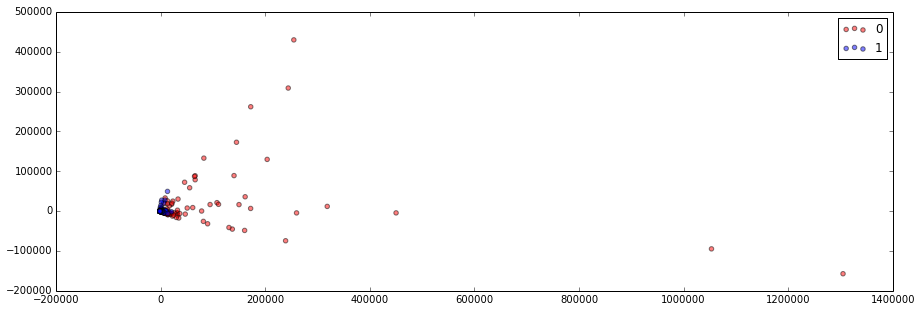

In [8]:
from sklearn.decomposition import PCA
X_ts = time_series[periods_str].values
Y_ts = time_series['Label'].values

pca = PCA(n_components=2)
X_ts_2d = pca.fit(X_ts, Y_ts).transform(X_ts)

plt.figure(figsize=(15,5))
plt.scatter(X_ts_2d[Y_ts==0, 0], X_ts_2d[Y_ts==0, 1], c='r', label='0', alpha=0.5)
plt.scatter(X_ts_2d[Y_ts==1, 0], X_ts_2d[Y_ts==1, 1], c='b', label='1', alpha=0.5)
plt.legend(loc='best')
plt.show()

#Применение классификатора

In [9]:
from sklearn.cross_validation import KFold

def Indexes_inverse(indexes):
    new_indexes = range(0,len(indexes))
    for i in range(0, len(indexes)):
        new_indexes[int(indexes[i])]=i
    return new_indexes

def KFold_predict_proba(estimator, X, Y, k):
    indexes = np.array([])
    Y_predict_proba = np.empty((0,2))
    kfold = KFold(n=X.shape[0], n_folds=k, random_state=42, shuffle=True)
    for train_index, test_index in kfold:
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        indexes = np.concatenate((indexes, test_index), axis=0)
        estimator.fit(X_train, Y_train)
        Y_predict_proba_test = estimator.predict_proba(X_test)
        Y_predict_proba = np.concatenate((Y_predict_proba, Y_predict_proba_test), axis=0)
    new_indexes = Indexes_inverse(indexes)
    return Y_predict_proba[list(new_indexes)]

In [10]:
%%time
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

estimator_ts = GradientBoostingClassifier(learning_rate=0.02, n_estimators=2500, max_depth=6, subsample=0.8)
Y_ts_proba = KFold_predict_proba(estimator=estimator_ts, X=X_ts, Y=Y_ts, k=3)

CPU times: user 4min 4s, sys: 305 ms, total: 4min 4s
Wall time: 4min 4s


Значимость признаков

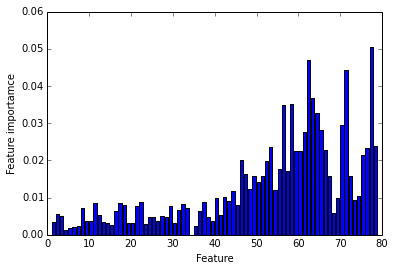

In [11]:
feature_imp = estimator_ts.feature_importances_
plt.bar(range(1,79), feature_imp)
plt.xlabel('Feature')
plt.ylabel('Feature importamce')
plt.show()

Строим ROC кривую. Получаем **baseline 1**.

ROC AUC is  0.921392996004


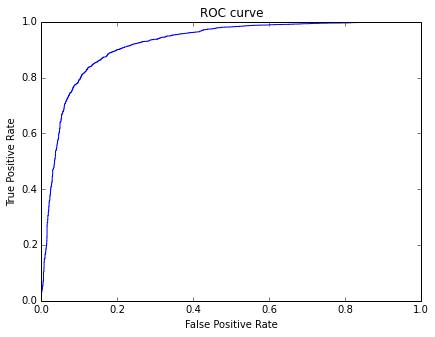

In [12]:
from sklearn.metrics import roc_curve, auc

fpr_ts, tpr_ts, _ = roc_curve(Y_ts, Y_ts_proba[:,1], pos_label=None, sample_weight=None)
roc_auc_ts = auc(fpr_ts, tpr_ts)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(fpr_ts, tpr_ts)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print 'ROC AUC is ', roc_auc_ts

Запишем baseline 1.

In [13]:
# bs1 = pd.DataFrame()
# bs1['fpr_ts'] = fpr_ts
# bs1['tpr_ts'] = tpr_ts
# bs1.to_csv('baseline1.csv')

###Тест на новых данных

In [18]:
data_test = pd.read_csv('../Data/time_series_reg_910days.csv')
data_test.irow(range(1,5))

,Unnamed: 0,Name,1,2,3,4,5,6,7,8,...,97,98,99,100,101,102,103,104,Label,Target
1,1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,0,0,804,...,0,0,0,0,0,0,0,0,1,0
2,2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,2189,0,1754,867,867,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,695,0,1370,0,685,685,685,0,...,0,0,0,0,0,0,0,0,1,0
4,4,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
periods_test = [str(i) for i in range(27, 105)]
X_test = data_test[periods_test].values
Y_test = data_test['Label'].values

In [20]:
%%time

Y_test_proba = estimator_ts.predict_proba(X_test)

CPU times: user 318 ms, sys: 590 µs, total: 319 ms
Wall time: 318 ms


In [1]:
import ipykee

/Users/mikhail91/.virtualenvs/rep_0_6_1/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


IOError: [Errno 2] No such file or directory: '/root/ipykee.cfg'

###Сравнение с baselines.

In [14]:
baseline1 = pd.read_csv('baseline1.csv')

ROC AUC is  0.921444514266


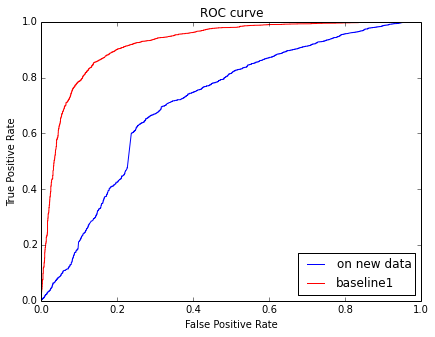

In [21]:
from sklearn.metrics import roc_curve, auc

fpr_test, tpr_test, _ = roc_curve(Y_test, Y_test_proba[:,1], pos_label=None, sample_weight=None)
roc_auc_ts = auc(baseline1['fpr_ts'].values, baseline1['tpr_ts'].values)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(fpr_test, tpr_test, label='on new data', c='b')
plt.plot(baseline1['fpr_ts'].values, baseline1['tpr_ts'].values, label='baseline1', c='r')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
print 'ROC AUC is ', roc_auc_ts

In [22]:
import ipykee

ImportError: No module named ipykee